In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

orig_df = pd.read_csv('simplelinearregression.csv')
df = orig_df.copy()

X = df[['Age']]
y = df['Premium']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [2]:
class H1Layer(Layer):
    def __init__(self, **kwargs):
        super(H1Layer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                 initializer='random_normal',
                                 trainable=True)
        super(H1Layer, self).build(input_shape)

    def call(self, x):
        return self.b * (2 * x)
        #return (2 * x) 

class H2Layer(Layer):
    def __init__(self, h1, **kwargs):
        super(H2Layer, self).__init__(**kwargs)
        self.h1 = h1

    def call(self, x):
        return (2*x*(self.h1(x)))-2
    
class H3Layer(Layer):
    def __init__(self, h1, h2, **kwargs):
        super(H3Layer, self).__init__(**kwargs)
        self.h1 = h1
        self.h2 = h2
        
    def call(self, x):
        return (2*x*(self.h2(x)))-(4*self.h1(x))

class H4Layer(Layer):
    def __init__(self, h2, h3, **kwargs):
        super(H4Layer, self).__init__(**kwargs)
        self.h2 = h2
        self.h3 = h3

    def call(self, x):
        return (2*x*(self.h3(x)))-(6*self.h2(x))   
    
class H5Layer(Layer):
    def __init__(self, h3, h4, **kwargs):
        super(H5Layer,self).__init__(**kwargs)
        self.h3 = h3
        self.h4 = h4

    def call(self,x):
        return (2*x*(self.h4(x)))-(8*self.h3(x))
    
class H6Layer(Layer):
    def __init__(self, h4, h5, **kwargs):
        super(H6Layer,self).__init__(**kwargs)
        self.h4 = h4
        self.h5 = h5

    def call(self,x):
        return (2*x*(self.h5(x)))-(10*self.h4(x))

class TensorDecompositionLayer(Layer):
    def __init__(self, rank, **kwargs):
        self.rank = rank
        super(TensorDecompositionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.factors_a = self.add_weight(shape=(input_shape[-1], self.rank),
                                         initializer='random_normal',
                                         trainable=True)
        self.factors_b = self.add_weight(shape=(self.rank, input_shape[-1]),
                                         initializer='random_normal',
                                         trainable=True)
        super(TensorDecompositionLayer, self).build(input_shape)

    def call(self, x):
        return tf.matmul(tf.matmul(x, self.factors_a), self.factors_b)


# N = 2

1/1 [==============================] - 0s 65ms/step
R-squared value: 0.8830063422050476
1/1 [==============================] - 0s 16ms/step


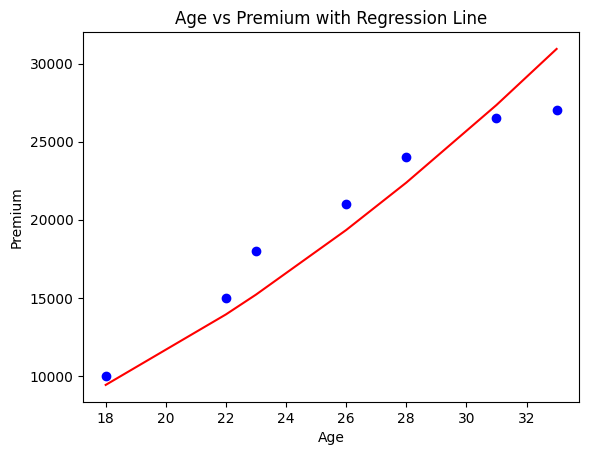

In [3]:

def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer(h1)
    x = Dense(filters)(x)
    x = h2(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (1,)
filters = 16
modelN2 = build_model(input_shape, filters)
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
modelN2.compile(optimizer=optimizer, loss='mse')

batch_size = 64
epochs = 150

# n_iter = 100
eps = 1e-8  # Smoothing to avoid division by zero
alpha =  1e-2 # 0.5 #1e-2
minibatch_size = 100
n_experiment = 3

history = modelN2.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(X_val, y_val))

val_loss = modelN2.evaluate(X_val, y_val, verbose=0)

y_pred = modelN2.predict(X_val)
r2_score_poly = r2_score(y_val, y_pred)

print(f"R-squared value: {r2_score_poly}")

import matplotlib.pyplot as plt
# Plot the regression line along with the data points
plt.scatter(X, y, color='blue')
plt.plot(X, modelN2.predict(X), color='red')
plt.title('Age vs Premium with Regression Line')
plt.xlabel('Age')
plt.ylabel('Premium')
plt.show()


# N = 4

Epoch 1/1000
1/1 [==============================] - 1s 1s/step - loss: 554454720.0000 - val_loss: 162500800.0000
Epoch 2/1000
1/1 [==============================] - 0s 27ms/step - loss: 554451584.0000 - val_loss: 162499072.0000
Epoch 3/1000
1/1 [==============================] - 0s 26ms/step - loss: 554448256.0000 - val_loss: 162497312.0000
Epoch 4/1000
1/1 [==============================] - 0s 27ms/step - loss: 554444928.0000 - val_loss: 162495536.0000
Epoch 5/1000
1/1 [==============================] - 0s 26ms/step - loss: 554441600.0000 - val_loss: 162493680.0000
Epoch 6/1000
1/1 [==============================] - 0s 26ms/step - loss: 554438272.0000 - val_loss: 162491744.0000
Epoch 7/1000
1/1 [==============================] - 0s 26ms/step - loss: 554434624.0000 - val_loss: 162489696.0000
Epoch 8/1000
1/1 [==============================] - 0s 27ms/step - loss: 554430784.0000 - val_loss: 162487504.0000
Epoch 9/1000
1/1 [==============================] - 0s 27ms/step - loss: 554426688

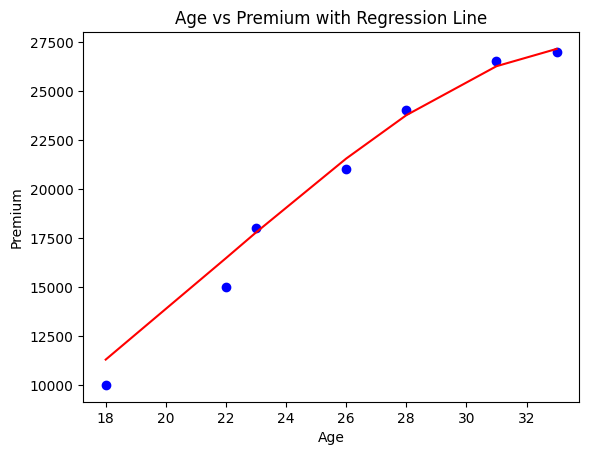

In [5]:

def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer(h1)
    h3 = H3Layer(h1,h2)
    h4 = H4Layer(h2,h3)
    x = Dense(filters)(x)
    x = h2(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h3(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h4(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 

input_shape = (1,)
filters = 16
modelN4 = build_model(input_shape, filters)
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
modelN4.compile(optimizer=optimizer, loss='mse')

batch_size = 64
epochs = 1000

# n_iter = 100
eps = 1e-8  # Smoothing to avoid division by zero
alpha =  1e-2 # 0.5 #1e-2
minibatch_size = 100
n_experiment = 3

history = modelN4.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val))

val_loss = modelN4.evaluate(X_val, y_val, verbose=0)

y_pred = modelN4.predict(X_val)
r2_score_poly = r2_score(y_val, y_pred)

print(f"R-squared value: {r2_score_poly}")

import matplotlib.pyplot as plt
# Plot the regression line along with the data points
plt.scatter(X, y, color='blue')
plt.plot(X, modelN4.predict(X), color='red')
plt.title('Age vs Premium with Regression Line')
plt.xlabel('Age')
plt.ylabel('Premium')
plt.show()


# N = 5

Epoch 1/400
1/1 [==============================] - 2s 2s/step - loss: 554441856.0000 - val_loss: 162491712.0000
Epoch 2/400
1/1 [==============================] - 0s 28ms/step - loss: 554434560.0000 - val_loss: 162487664.0000
Epoch 3/400
1/1 [==============================] - 0s 28ms/step - loss: 554427008.0000 - val_loss: 162483104.0000
Epoch 4/400
1/1 [==============================] - 0s 29ms/step - loss: 554418432.0000 - val_loss: 162477728.0000
Epoch 5/400
1/1 [==============================] - 0s 30ms/step - loss: 554408448.0000 - val_loss: 162471456.0000
Epoch 6/400
1/1 [==============================] - 0s 28ms/step - loss: 554396672.0000 - val_loss: 162464080.0000
Epoch 7/400
1/1 [==============================] - 0s 29ms/step - loss: 554382912.0000 - val_loss: 162455488.0000
Epoch 8/400
1/1 [==============================] - 0s 29ms/step - loss: 554366848.0000 - val_loss: 162445536.0000
Epoch 9/400
1/1 [==============================] - 0s 29ms/step - loss: 554348416.0000 - v

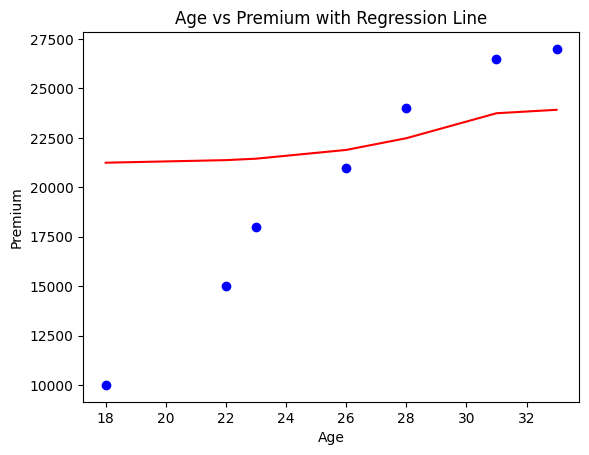

In [3]:

def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer(h1)
    h3 = H3Layer(h1,h2)
    h4 = H4Layer(h2,h3)
    h5 = H5Layer(h3,h4)
    x = Dense(filters)(x)
    x = h2(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h3(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h4(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h5(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)

    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (1,)
filters = 16
modelN5 = build_model(input_shape, filters)
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
modelN5.compile(optimizer=optimizer, loss='mse')

batch_size = 64
epochs = 400

# n_iter = 100
eps = 1e-8  # Smoothing to avoid division by zero
alpha =  1e-2 # 0.5 #1e-2
minibatch_size = 100
n_experiment = 3

history = modelN5.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val))

val_loss = modelN5.evaluate(X_val, y_val, verbose=0)

y_pred = modelN5.predict(X_val)
r2_score_poly = r2_score(y_val, y_pred)

print(f"R-squared value: {r2_score_poly}")

import matplotlib.pyplot as plt
# Plot the regression line along with the data points
plt.scatter(X, y, color='blue')
plt.plot(X, modelN5.predict(X), color='red')
plt.title('Age vs Premium with Regression Line')
plt.xlabel('Age')
plt.ylabel('Premium')
plt.show()


